Try to combine the binary classification NN and categorical classification NN in a mixed model

In [12]:
import numpy as np
# Load X and y
X = np.load('input_output/X_rhythm.npy')
y = np.load('input_output/y_rhythm.npy')

n_cl = 5

# Load the two NN models
from tensorflow.keras.models import load_model
NN_binary = load_model('models/NN_rhythm_binary.keras')
NN_categorical = load_model('models/NN_rhythm_categorical_1_4.keras')

In [13]:
def mixed_model(X):
    # Predict health status: shape (n_patients, 2)
    healthy_pred = NN_binary.predict(X)
    # Healthy if [0,1], i.e., argmax==1
    is_healthy = np.argmax(healthy_pred, axis=1) == 1

    # Prepare output: shape (n_patients, 5)
    out = np.zeros((X.shape[0], n_cl), dtype=np.float32)

    # For healthy patients, set class 4 (zero-based)
    out[is_healthy, n_cl-1] = 1

    # For unhealthy patients, get categorical prediction (shape: [n_unhealthy, 4])
    if np.any(~is_healthy):
        cat_pred = NN_categorical.predict(X[~is_healthy])  # shape: (n_unhealthy, 4)
        out[~is_healthy, :n_cl-1] = cat_pred  # Fill first 4 classes

    return out

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 score: 0.7635290887412409


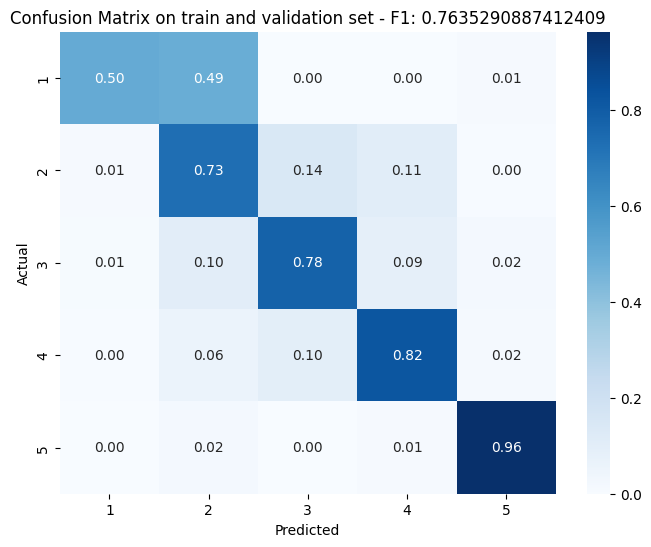

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predicted labels
y_true = np.argmax((y), axis=-1)
y_pred = np.argmax(mixed_model(X), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set - F1: {f1}')
plt.show()

In [15]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
F1 score: 0.75963414881384


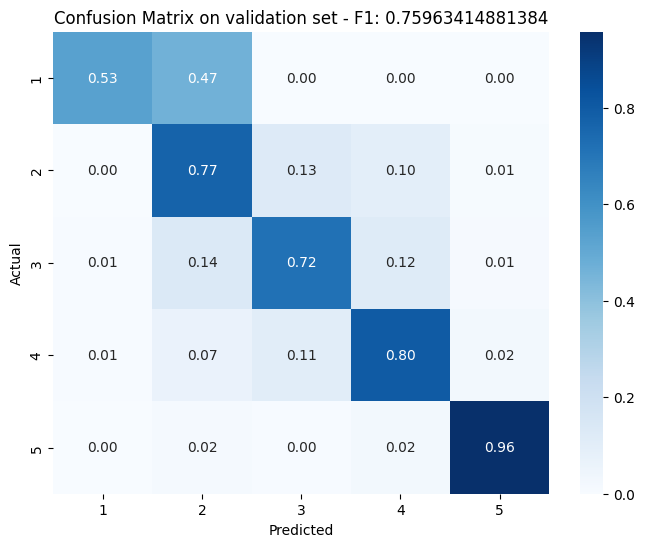

In [16]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val, axis=-1)
y_pred = np.argmax(mixed_model(X_val), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set - F1: {f1}')
plt.show()

Now try with Male / Female Models

In [17]:
import numpy as np
# Load X and y
X_m = np.load('input_output/XM_rhythm.npy')
X_f = np.load('input_output/XF_rhythm.npy')
y_m = np.load('input_output/yM_rhythm.npy')
y_f = np.load('input_output/yF_rhythm.npy')

n_cl = 5

# Load the two NN models
from tensorflow.keras.models import load_model
NN_binary_M = load_model('models/NN_rhythm_binary_M.keras')
NN_binary_F = load_model('models/NN_rhythm_binary_F.keras')

NN_categorical_M = load_model('models/NN_rhythm_categorical_1_4_M.keras')
NN_categorical_F = load_model('models/NN_rhythm_categorical_1_4_F.keras')

In [18]:
def mixed_model_M(X):
    # Predict health status: shape (n_patients, 2)
    healthy_pred = NN_binary_M.predict(X)
    # Healthy if [0,1], i.e., argmax==1
    is_healthy = np.argmax(healthy_pred, axis=1) == 1

    # Prepare output: shape (n_patients, 5)
    out = np.zeros((X.shape[0], n_cl), dtype=np.float32)

    # For healthy patients, set class 4 (zero-based)
    out[is_healthy, n_cl-1] = 1

    # For unhealthy patients, get categorical prediction (shape: [n_unhealthy, 4])
    if np.any(~is_healthy):
        cat_pred = NN_categorical_M.predict(X[~is_healthy])  # shape: (n_unhealthy, 4)
        out[~is_healthy, :n_cl-1] = cat_pred  # Fill first 4 classes

    return out

def mixed_model_F(X):
    # Predict health status: shape (n_patients, 2)
    healthy_pred = NN_binary_F.predict(X)
    # Healthy if [0,1], i.e., argmax==1
    is_healthy = np.argmax(healthy_pred, axis=1) == 1

    # Prepare output: shape (n_patients, 5)
    out = np.zeros((X.shape[0], n_cl), dtype=np.float32)

    # For healthy patients, set class 4 (zero-based)
    out[is_healthy, n_cl-1] = 1

    # For unhealthy patients, get categorical prediction (shape: [n_unhealthy, 4])
    if np.any(~is_healthy):
        cat_pred = NN_categorical_F.predict(X[~is_healthy])  # shape: (n_unhealthy, 4)
        out[~is_healthy, :n_cl-1] = cat_pred  # Fill first 4 classes

    return out

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 score: 0.8403470816798819


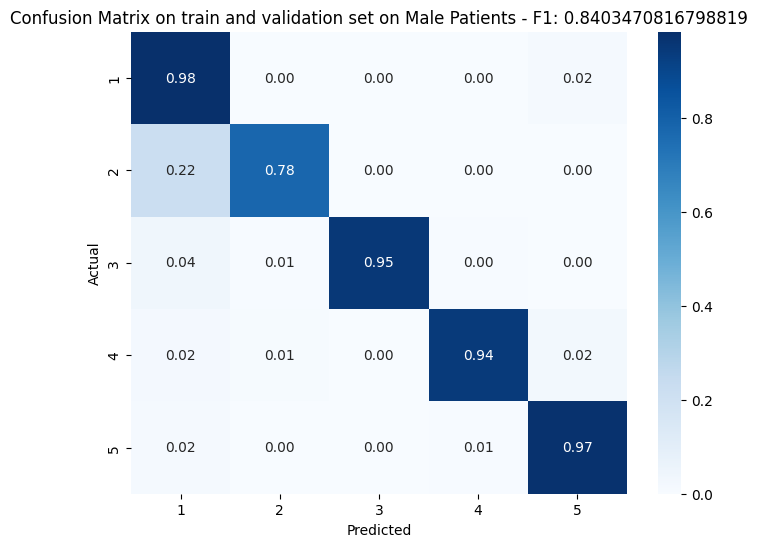

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 score: 0.8521834640386132


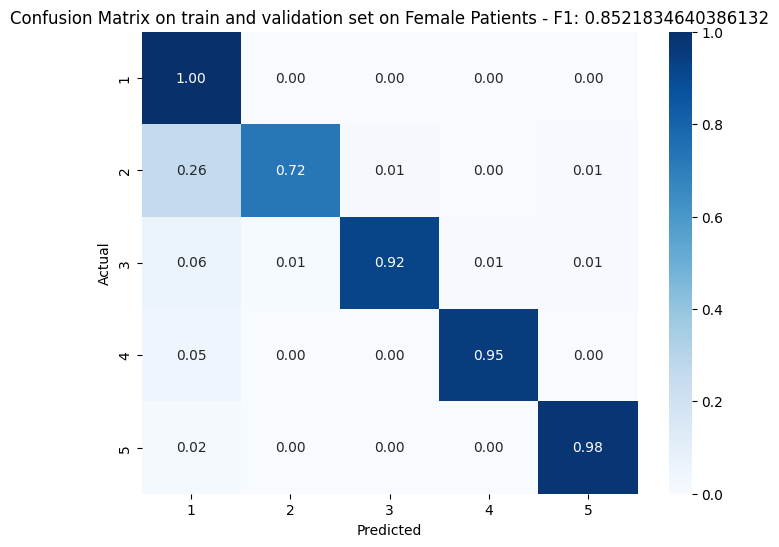

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 score: 0.8474062660046862


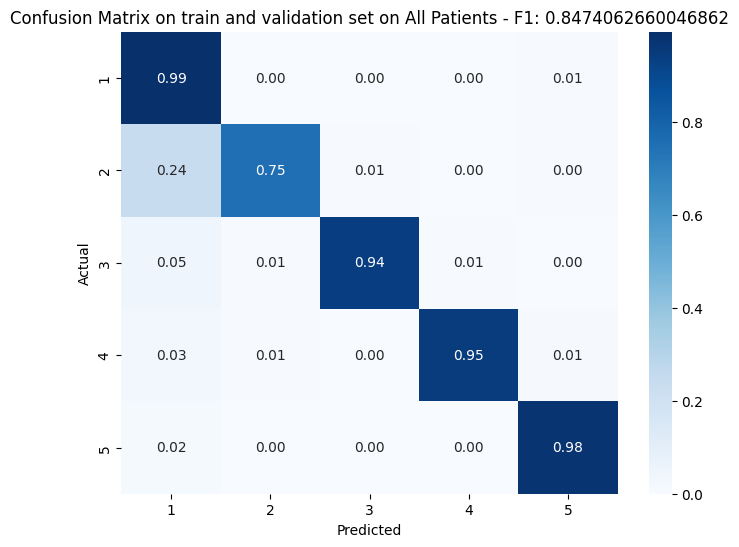

In [19]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predicted labels
y_true = np.argmax((y_m), axis=-1)
y_pred = np.argmax(mixed_model_M(X_m), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set on Male Patients - F1: {f1}')
plt.show()

# Example true labels and predicted labels
y_true = np.argmax((y_f), axis=-1)
y_pred = np.argmax(mixed_model_F(X_f), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set on Female Patients - F1: {f1}')
plt.show()

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_m, y_f)), axis=-1)
y_pred = np.argmax(np.concatenate((mixed_model_M(X_m), mixed_model_F(X_f))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set on All Patients - F1: {f1}')
plt.show()

In [20]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42, stratify=y_m.argmax(axis=1))
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42, stratify=y_f.argmax(axis=1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1 score: 0.8483175153668825


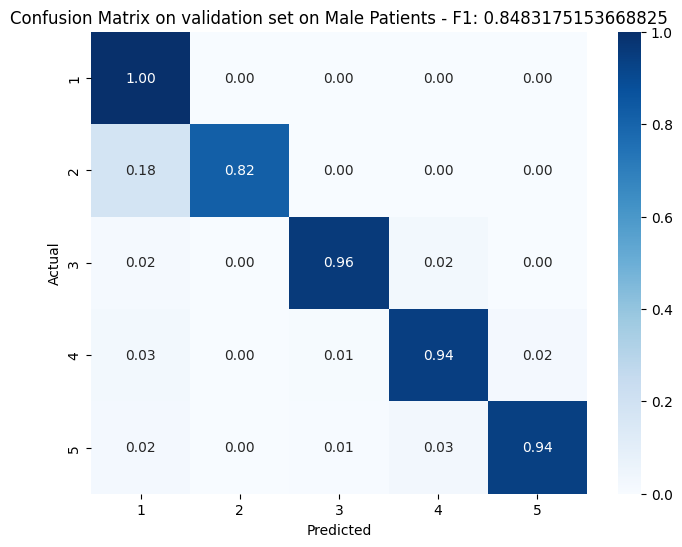

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
F1 score: 0.854790801269024


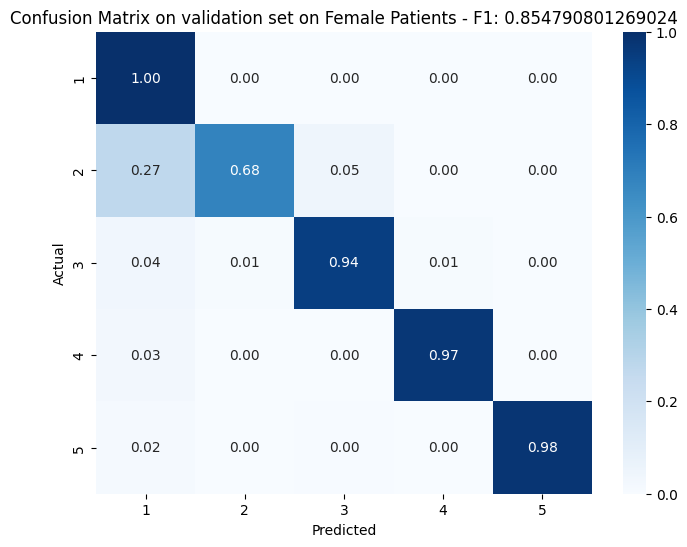

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
F1 score: 0.8515774449727674


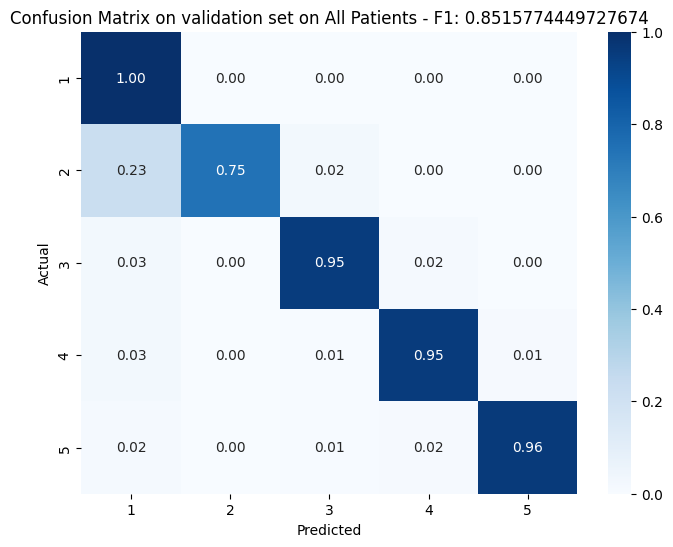

In [21]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predicted labels
y_true = np.argmax((y_val_m), axis=-1)
y_pred = np.argmax(mixed_model_M(X_val_m), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set on Male Patients - F1: {f1}')
plt.show()

# Example true labels and predicted labels
y_true = np.argmax((y_val_f), axis=-1)
y_pred = np.argmax(mixed_model_F(X_val_f), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set on Female Patients - F1: {f1}')
plt.show()

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val_m, y_val_f)), axis=-1)
y_pred = np.argmax(np.concatenate((mixed_model_M(X_val_m), mixed_model_F(X_val_f))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set on All Patients - F1: {f1}')
plt.show()